In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# Import custom methods
import sys
sys.path.append("../") # go to parent dir
from utilities import utilities as utils

# Ignore deprecation warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
pickle_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/pickles/')
fig_path = Path('/Users/andreakeane/Documents/DataScience/GridCure_Problems/figures/')

test = pd.read_pickle(pickle_path / "test.pkl")
train = pd.read_pickle(pickle_path / "train.pkl")
labels = pd.read_pickle(pickle_path / "labels.pkl")
houses_wEV = utils.get_pickle(pickle_path / "houses_wEV.pkl")
houses_woEV = utils.get_pickle(pickle_path / "houses_woEV.pkl")

# Determine outliers
outliers = utils.classify_outliers(train)


Number of Outliers: 37
Percent Removed: 2.33%



In [8]:
# Verify that we don't have any negative readings
# This indicates a fundamental error in the data measurement
test = np.where(train.stack() < 0, True, False)
for value in test: 
    if value == True: 
        print("Error. Training data contains negative values.")
        break
else:
    print("No negative power readings in the dataset.")

No negative power readings in the dataset.


In [9]:
# Ratio of houses with and without EVs
ct_w = len(houses_wEV)
ct_wo = len(houses_woEV)
print("{:.2f}% of the training data houses own EVs".format(100*ct_w/(ct_w + ct_wo)))

# Separate into houses with and without EVs
train_w = train.drop(houses_woEV)
train_wo = train.drop(houses_wEV)
labels_w = labels.drop(houses_woEV)
# labels_wo is zero matrix

30.50% of the training data houses own EVs


In [19]:
# Overall Imbalance
labels_stack = labels.drop(outliers.index).stack()
vc = labels_stack.value_counts()
pct_chrg =  100 * vc[1]/(vc[0] + vc[1])

print("EVs charged during {:.2f}% of all intervals\n"
      "  {} Charging intervals\n"
      "  {} Non-Charing intervals\n\n".format(pct_chrg, vc[1], vc[0]))

# Imbalance for EV-only
labels_stack = labels_w.drop(outliers.index, errors='ignore').stack()
vc = labels_stack.value_counts()
pct_chrg =  100 * vc[1]/(vc[0] + vc[1])

print("EVs charged during {:.2f}% of all intervals at hosues with EVs\n"
      "  {} Charging intervals\n"
      "  {} Non-Charing intervals".format(pct_chrg, vc[1], vc[0]))

EVs charged during 2.36% of all intervals
  105550 Charging intervals
  4367090 Non-Charing intervals


EVs charged during 7.67% of all intervals at hosues with EVs
  105550 Charging intervals
  1271090 Non-Charing intervals


In [11]:
# Determine stats for both classifications
stats = pd.DataFrame(index=train.index)
stats['tot_pwr'] = train.sum(axis=1)
stats['avg_pwr'] = train.mean(axis=1)
stats['median_pwr'] = train.median(axis=1)
stats['min_pwr'] = train.min(axis=1)
stats['max_pwr'] = train.max(axis=1)
stats['tot_chrgs'] = labels.sum(axis=1)
stats['bool_EV'] = np.where(stats['tot_chrgs'] > 0, True, False)

stats.drop(outliers.index, errors='ignore', inplace=True)

In [12]:
# Split stats by class
stats_wEV = stats.drop(houses_woEV, errors='ignore').drop(outliers.index, errors='ignore')
stats_woEV = stats.drop(houses_wEV, errors='ignore').drop(outliers.index, errors='ignore')


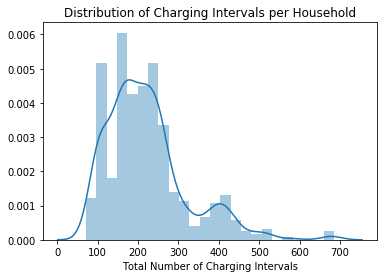

In [13]:
# Distribution of the number of charges
plot = sns.distplot(stats_wEV['tot_chrgs'].values);
plt.title('Distribution of Charging Intervals per Household');
plt.xlabel('Total Number of Charging Intervals');
plot.get_figure().savefig(fig_path / "labels_dist_tot_chrgs.png")

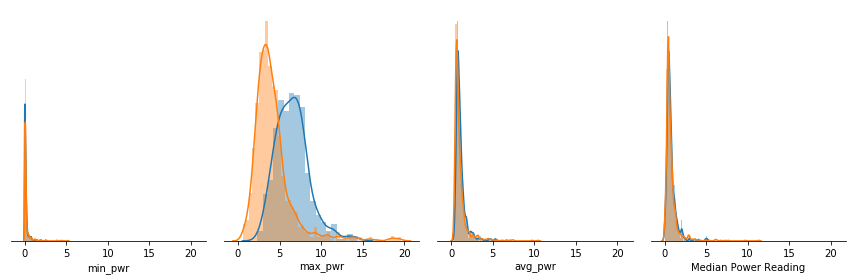

In [14]:
# Plot distribution of summary stats
# Set up the matplotlib figure
f, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharex=True)
sns.despine(left=True)

# Min Power Reading
sns.distplot(stats_wEV['min_pwr'], ax=axes[0])
sns.distplot(stats_woEV['min_pwr'], ax=axes[0])
plt.xlabel('Minimum Power Reading');

# Max Power Reading
sns.distplot(stats_wEV['max_pwr'], ax=axes[1])
sns.distplot(stats_woEV['max_pwr'], ax=axes[1])
plt.xlabel('Maximum Power Reading');

# Mean Power Reading
sns.distplot(stats_wEV['avg_pwr'], ax=axes[2])
sns.distplot(stats_woEV['avg_pwr'], ax=axes[2])
plt.xlabel('Average Power Reading');

# Median Power Reading
sns.distplot(stats_wEV['median_pwr'], ax=axes[3])
sns.distplot(stats_woEV['median_pwr'], ax=axes[3])
plt.xlabel('Median Power Reading');


plt.setp(axes, yticks=[])
plt.tight_layout()
f.savefig(fig_path / "stats_subplots.png")